In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from itertools import product
import json 
import csv
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
df=pd.read_csv("dftouse.csv")

In [3]:
del df['Unnamed: 0']
del df['ReserveMet']
del df['ListingStatus']
#del dftouse['MinimumToBid']
df = df[pd.isnull(df.HitCount) == False]

In [4]:
dftouse = df.copy()
dftouse.head()

,country,itemId,paymentMethod,postalCode,sellingStatus,topRatedListing,AutoPay,AvailableForPickupDropOff,BestOfferEnabled,BidCount,BuyItNowPrice,FinalPrice,GlobalShipping,HandlingTime,HitCount,ListingType,Location,MinimumToBid,ProductID,Quantity,QuantityThreshold,ShipToLocations,Title,UserID,FeedbackScore,PositiveFeedbackPercent,SellerBusinessType,NewUser,nPhotos,nPaymentMethods,nShippingCountries,conditionId,bestOfferEnabled,buyItNowAvailable,expeditedShipping,shippingType,oneDayShippingAvailable,RatingsPresent,AverageRating,NegFeedback30Day,NegFeedback365Day,PosFeedback30Day,PosFeedback365Day,auctionLength
0,0,131642735687,0,10590,0,False,False,0,False,41,NaN,202.09,False,2,190,0,"South Salem, New York",204.59,NaN,1,0,US,iPhone 5s-32gb-Space Gray-unlocked,jdwein1980,19,100.0,2,False,3,1,1,5,False,False,True,2,False,False,NaN,0,0,5,5,168
1,0,262126933108,0,35004,0,False,False,0,False,4,NaN,260.00,False,3,32,0,"Moody, Alabama",265.00,NaN,1,0,US,apple iphone 5s 32gb,forwhlrcr1965,565,100.0,1,False,2,1,1,5,False,False,True,0,False,False,NaN,0,0,3,32,120
2,0,252155964081,0,98104,0,False,False,0,False,3,NaN,152.50,False,2,168,0,"Seattle, Washington",155.00,168534287,1,0,Worldwide,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,15,94.1,1,False,2,1,1,5,False,False,False,1,False,False,NaN,0,1,2,17,120
3,0,252163774777,0,98104,0,False,False,0,False,1,NaN,99.00,False,2,143,0,"Seattle, Washington",100.00,168553370,1,0,US,Apple iPhone 5s - 32GB - Silver (Verizon) Smar...,15-alice,15,94.1,1,False,7,1,1,9,False,False,True,0,False,False,NaN,0,1,2,17,120
4,0,252171170160,0,98104,0,False,True,0,False,5,NaN,96.00,False,2,357,0,"Seattle, Washington",97.00,168534287,1,0,US,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,15,94.1,1,False,2,1,1,5,False,False,False,1,False,False,NaN,0,1,2,17,120


In [5]:
ZERO_IMPORTANT_VARIABLES = ['BidCount', 'HitCount', 'nPhotos', 'FeedbackScore', 'PositiveFeedbackPercent',
                           'NegFeedback30Day', 'NegFeedback365Day', 'PosFeedback30Day', 'PosFeedback365Day']
STANDARDIZABLE = ZERO_IMPORTANT_VARIABLES + ['FinalPrice','auctionLength', 'HandlingTime', 'FeedbackScore', 
                  'PositiveFeedbackPercent', 'Quantity', 'nPaymentMethods', 'nShippingCountries', 'auctionLength']
INDICATORS = []

In [6]:
for v in df.columns:
    if v != 'sellingStatus':
        l=df[v].unique()
        if len(l) <= 10:
            if v not in STANDARDIZABLE:
                dftouse.rename(columns={v:'i_'+v}, inplace=True)
                INDICATORS.append('i_'+v)
            else:
                dftouse['i_'+v]=(dftouse[v] > 0.0)*1
                INDICATORS.append('i_'+v)
            print v, l

for v in ZERO_IMPORTANT_VARIABLES:
    dftouse['i_'+v]=(dftouse[v] > 0.0)*1
    INDICATORS.append('i_'+v)
    print v
    
#INDICATORS.remove('i_sellingStatus')
print INDICATORS


country [0 1]
paymentMethod [0 1]
topRatedListing [False True]
AutoPay [False True]
AvailableForPickupDropOff [0 1]
BestOfferEnabled [False True]
GlobalShipping [False True]
HandlingTime [ 2.  3.  1.  0.]
ListingType [0 1]
QuantityThreshold [  0.  10.]
SellerBusinessType [2 1 0]
NewUser [False True]
nPaymentMethods [1 2 4 3]
conditionId [5 9 0 1 3 4]
bestOfferEnabled [False True]
buyItNowAvailable [False True]
expeditedShipping [True False]
shippingType [ 2.  0.  1.  3.  4.  8.]
oneDayShippingAvailable [False True]
RatingsPresent [False True]
BidCount
HitCount
nPhotos
FeedbackScore
PositiveFeedbackPercent
NegFeedback30Day
NegFeedback365Day
PosFeedback30Day
PosFeedback365Day
['i_country', 'i_paymentMethod', 'i_topRatedListing', 'i_AutoPay', 'i_AvailableForPickupDropOff', 'i_BestOfferEnabled', 'i_GlobalShipping', 'i_HandlingTime', 'i_ListingType', 'i_QuantityThreshold', 'i_SellerBusinessType', 'i_NewUser', 'i_nPaymentMethods', 'i_conditionId', 'i_bestOfferEnabled', 'i_buyItNowAvailable',

In [7]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.7)

In [8]:
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [9]:
mask

array([ True,  True, False, ...,  True, False,  True], dtype=bool)

In [10]:
mask.shape, mask.sum()

((9267,), 6486)

In [11]:
from sklearn import preprocessing

#we make our training and testing sets w/ standarized
scaler = preprocessing.StandardScaler().fit(dftouse[mask][STANDARDIZABLE])
dftouse.loc[mask, STANDARDIZABLE] = scaler.transform(dftouse[mask][STANDARDIZABLE]) 
dftouse.loc[~mask,STANDARDIZABLE] = scaler.transform(dftouse[~mask][STANDARDIZABLE])


dftouse[mask].head()

,i_country,itemId,i_paymentMethod,postalCode,sellingStatus,i_topRatedListing,i_AutoPay,i_AvailableForPickupDropOff,i_BestOfferEnabled,BidCount,BuyItNowPrice,FinalPrice,i_GlobalShipping,HandlingTime,HitCount,i_ListingType,Location,MinimumToBid,ProductID,Quantity,i_QuantityThreshold,ShipToLocations,Title,UserID,FeedbackScore,PositiveFeedbackPercent,i_SellerBusinessType,i_NewUser,nPhotos,nPaymentMethods,nShippingCountries,i_conditionId,i_bestOfferEnabled,i_buyItNowAvailable,i_expeditedShipping,i_shippingType,i_oneDayShippingAvailable,i_RatingsPresent,AverageRating,NegFeedback30Day,NegFeedback365Day,PosFeedback30Day,PosFeedback365Day,auctionLength,i_HandlingTime,i_nPaymentMethods,i_BidCount,i_HitCount,i_nPhotos,i_FeedbackScore,i_PositiveFeedbackPercent,i_NegFeedback30Day,i_NegFeedback365Day,i_PosFeedback30Day,i_PosFeedback365Day
0,0,131642735687,0,10590,0,False,False,0,False,2.674272,NaN,-0.452315,False,0.417253,-0.037235,0,"South Salem, New York",204.59,NaN,-0.046664,0,US,iPhone 5s-32gb-Space Gray-unlocked,jdwein1980,-0.233904,0.306798,2,False,-0.810229,-0.067592,-0.825903,5,False,False,True,2,False,False,NaN,-0.157069,-0.235836,-0.272754,-0.307403,0.054080,1,1,1,1,1,1,1,0,0,1,1
1,0,262126933108,0,35004,0,False,False,0,False,-0.231051,NaN,0.049679,False,1.785457,-0.056784,0,"Moody, Alabama",265.00,NaN,-0.046664,0,US,apple iphone 5s 32gb,forwhlrcr1965,-0.213972,0.306798,1,False,-1.138388,-0.067592,-0.825903,5,False,False,True,0,False,False,NaN,-0.157069,-0.235836,-0.281091,-0.298609,-0.054168,1,1,1,1,1,1,1,0,0,1,1
3,0,252163774777,0,98104,0,False,False,0,False,-0.466618,NaN,-1.345952,False,0.417253,-0.043051,0,"Seattle, Washington",100.00,168553370,-0.046664,0,US,Apple iPhone 5s - 32GB - Silver (Verizon) Smar...,15-alice,-0.234050,0.082573,1,False,0.502408,-0.067592,-0.825903,9,False,False,True,0,False,False,NaN,-0.157069,-0.201689,-0.285260,-0.303494,-0.054168,1,1,1,1,1,1,1,0,1,1,1
4,0,252171170160,0,98104,0,False,True,0,False,-0.152529,NaN,-1.371957,False,0.417253,-0.016573,0,"Seattle, Washington",97.00,168534287,-0.046664,0,US,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,-0.234050,0.082573,1,False,-1.138388,-0.067592,-0.825903,5,False,False,False,1,False,False,NaN,-0.157069,-0.201689,-0.285260,-0.303494,-0.054168,1,1,1,1,1,1,1,0,1,1,1
5,0,252171162991,0,98104,0,False,False,0,False,-0.309573,NaN,-1.493317,False,0.417253,-0.023007,0,"Seattle, Washington",83.00,168553370,-0.046664,0,US,Apple iPhone 5s - 32GB - Silver (Verizon) Smar...,15-alice,-0.234050,0.082573,1,False,0.502408,-0.067592,-0.825903,9,False,False,True,0,False,False,NaN,-0.157069,-0.201689,-0.285260,-0.303494,-0.054168,1,1,1,1,1,1,1,0,1,1,1


In [12]:
lcols=list(dftouse.columns)
print lcols
lcols.remove(u'sellingStatus')
print len(lcols)

['i_country', 'itemId', 'i_paymentMethod', 'postalCode', 'sellingStatus', 'i_topRatedListing', 'i_AutoPay', 'i_AvailableForPickupDropOff', 'i_BestOfferEnabled', 'BidCount', 'BuyItNowPrice', 'FinalPrice', 'i_GlobalShipping', 'HandlingTime', 'HitCount', 'i_ListingType', 'Location', 'MinimumToBid', 'ProductID', 'Quantity', 'i_QuantityThreshold', 'ShipToLocations', 'Title', 'UserID', 'FeedbackScore', 'PositiveFeedbackPercent', 'i_SellerBusinessType', 'i_NewUser', 'nPhotos', 'nPaymentMethods', 'nShippingCountries', 'i_conditionId', 'i_bestOfferEnabled', 'i_buyItNowAvailable', 'i_expeditedShipping', 'i_shippingType', 'i_oneDayShippingAvailable', 'i_RatingsPresent', 'AverageRating', 'NegFeedback30Day', 'NegFeedback365Day', 'PosFeedback30Day', 'PosFeedback365Day', 'auctionLength', 'i_HandlingTime', 'i_nPaymentMethods', 'i_BidCount', 'i_HitCount', 'i_nPhotos', 'i_FeedbackScore', 'i_PositiveFeedbackPercent', 'i_NegFeedback30Day', 'i_NegFeedback365Day', 'i_PosFeedback30Day', 'i_PosFeedback365Day'

In [13]:
#type(dftouse['i_ShipToLocations'][0])

In [14]:
ccols=[]
for c in lcols:
    if c not in INDICATORS:
        ccols.append(c)


ccols.remove('itemId')
ccols.remove('postalCode')
#ccols.remove('sellingStatus')
ccols.remove('Location')
ccols.remove('ProductID')
ccols.remove('ShipToLocations')
ccols.remove('Title')
ccols.remove('UserID')
print len(ccols), len(INDICATORS)

18 29


In [15]:
dftouse.head()

,i_country,itemId,i_paymentMethod,postalCode,sellingStatus,i_topRatedListing,i_AutoPay,i_AvailableForPickupDropOff,i_BestOfferEnabled,BidCount,BuyItNowPrice,FinalPrice,i_GlobalShipping,HandlingTime,HitCount,i_ListingType,Location,MinimumToBid,ProductID,Quantity,i_QuantityThreshold,ShipToLocations,Title,UserID,FeedbackScore,PositiveFeedbackPercent,i_SellerBusinessType,i_NewUser,nPhotos,nPaymentMethods,nShippingCountries,i_conditionId,i_bestOfferEnabled,i_buyItNowAvailable,i_expeditedShipping,i_shippingType,i_oneDayShippingAvailable,i_RatingsPresent,AverageRating,NegFeedback30Day,NegFeedback365Day,PosFeedback30Day,PosFeedback365Day,auctionLength,i_HandlingTime,i_nPaymentMethods,i_BidCount,i_HitCount,i_nPhotos,i_FeedbackScore,i_PositiveFeedbackPercent,i_NegFeedback30Day,i_NegFeedback365Day,i_PosFeedback30Day,i_PosFeedback365Day
0,0,131642735687,0,10590,0,False,False,0,False,2.674272,NaN,-0.452315,False,0.417253,-0.037235,0,"South Salem, New York",204.59,NaN,-0.046664,0,US,iPhone 5s-32gb-Space Gray-unlocked,jdwein1980,-0.233904,0.306798,2,False,-0.810229,-0.067592,-0.825903,5,False,False,True,2,False,False,NaN,-0.157069,-0.235836,-0.272754,-0.307403,0.054080,1,1,1,1,1,1,1,0,0,1,1
1,0,262126933108,0,35004,0,False,False,0,False,-0.231051,NaN,0.049679,False,1.785457,-0.056784,0,"Moody, Alabama",265.00,NaN,-0.046664,0,US,apple iphone 5s 32gb,forwhlrcr1965,-0.213972,0.306798,1,False,-1.138388,-0.067592,-0.825903,5,False,False,True,0,False,False,NaN,-0.157069,-0.235836,-0.281091,-0.298609,-0.054168,1,1,1,1,1,1,1,0,0,1,1
2,0,252155964081,0,98104,0,False,False,0,False,-0.309573,NaN,-0.882186,False,0.417253,-0.039957,0,"Seattle, Washington",155.00,168534287,-0.046664,0,Worldwide,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,-0.234050,0.082573,1,False,-1.138388,-0.067592,-0.825903,5,False,False,False,1,False,False,NaN,-0.157069,-0.201689,-0.285260,-0.303494,-0.054168,1,1,1,1,1,1,1,0,1,1,1
3,0,252163774777,0,98104,0,False,False,0,False,-0.466618,NaN,-1.345952,False,0.417253,-0.043051,0,"Seattle, Washington",100.00,168553370,-0.046664,0,US,Apple iPhone 5s - 32GB - Silver (Verizon) Smar...,15-alice,-0.234050,0.082573,1,False,0.502408,-0.067592,-0.825903,9,False,False,True,0,False,False,NaN,-0.157069,-0.201689,-0.285260,-0.303494,-0.054168,1,1,1,1,1,1,1,0,1,1,1
4,0,252171170160,0,98104,0,False,True,0,False,-0.152529,NaN,-1.371957,False,0.417253,-0.016573,0,"Seattle, Washington",97.00,168534287,-0.046664,0,US,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,-0.234050,0.082573,1,False,-1.138388,-0.067592,-0.825903,5,False,False,False,1,False,False,NaN,-0.157069,-0.201689,-0.285260,-0.303494,-0.054168,1,1,1,1,1,1,1,0,1,1,1


BidCount
BuyItNowPrice
FinalPrice
HandlingTime
HitCount
MinimumToBid
Quantity
FeedbackScore
PositiveFeedbackPercent
nPhotos
nPaymentMethods
nShippingCountries
AverageRating
NegFeedback30Day
NegFeedback365Day
PosFeedback30Day
PosFeedback365Day
auctionLength

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
//anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


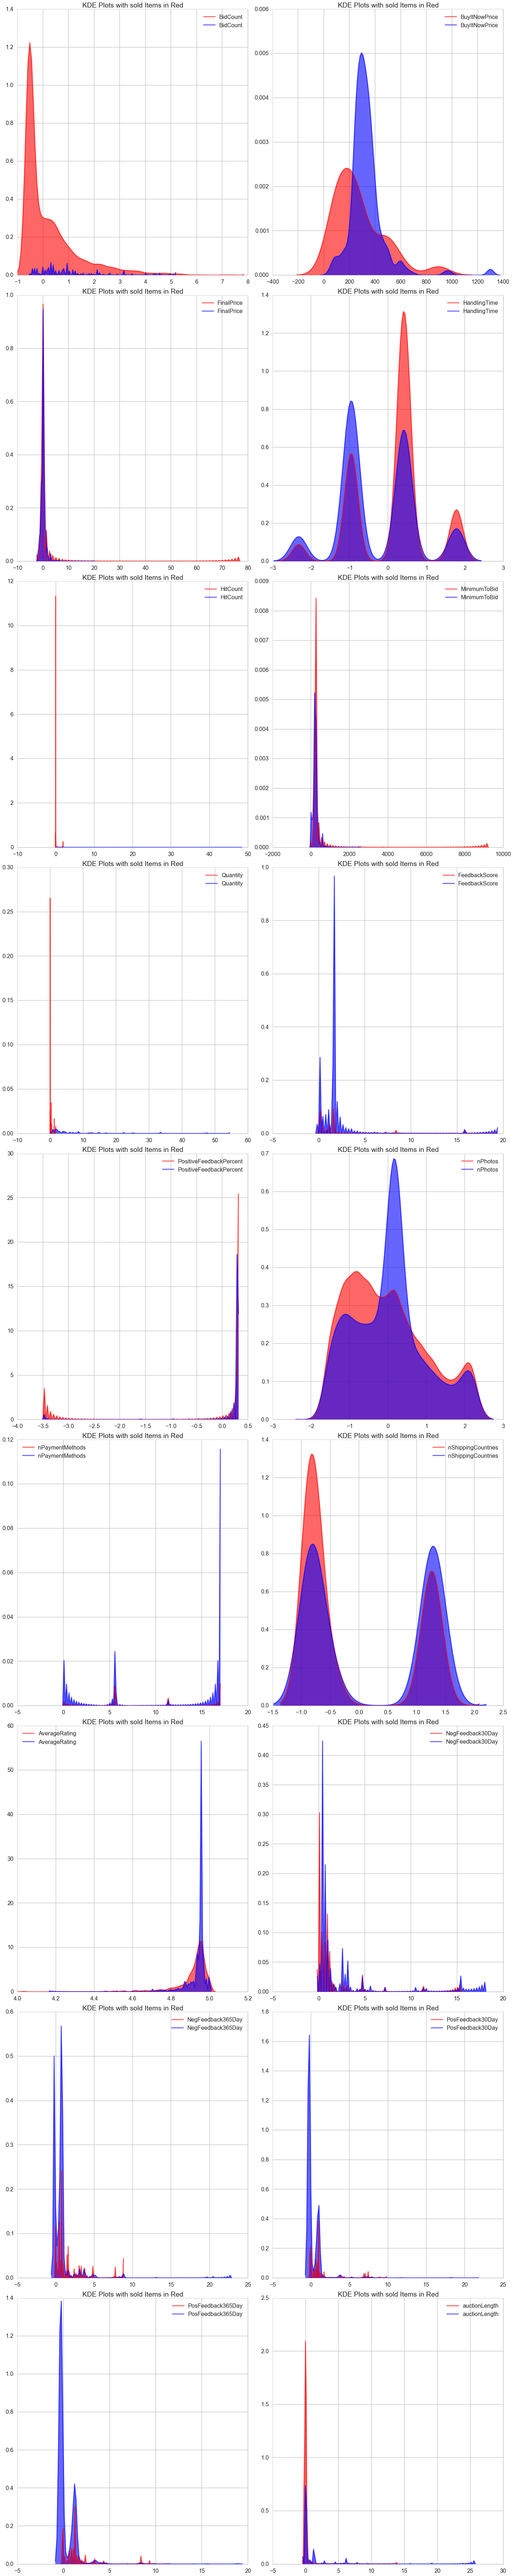

In [16]:
fig, axes = plt.subplots(nrows=9, ncols=2, sharex=False, sharey=False, figsize=(20, 100), 
                         tight_layout=True)
for ax, ccol in zip(axes.ravel(), ccols):
    
    #plot mean values per year based on response to mailing
    df_col = dftouse[ccol]
    print ccol
    sns.kdeplot(df_col[dftouse['sellingStatus'] == 0], color='r', alpha=.6, ax=ax, shade=True, legend=True)
    sns.kdeplot(df_col[dftouse['sellingStatus'] == 1], color='b', alpha=.6, ax=ax, shade=True)
    ax.set_title("KDE Plots with sold Items in Red")

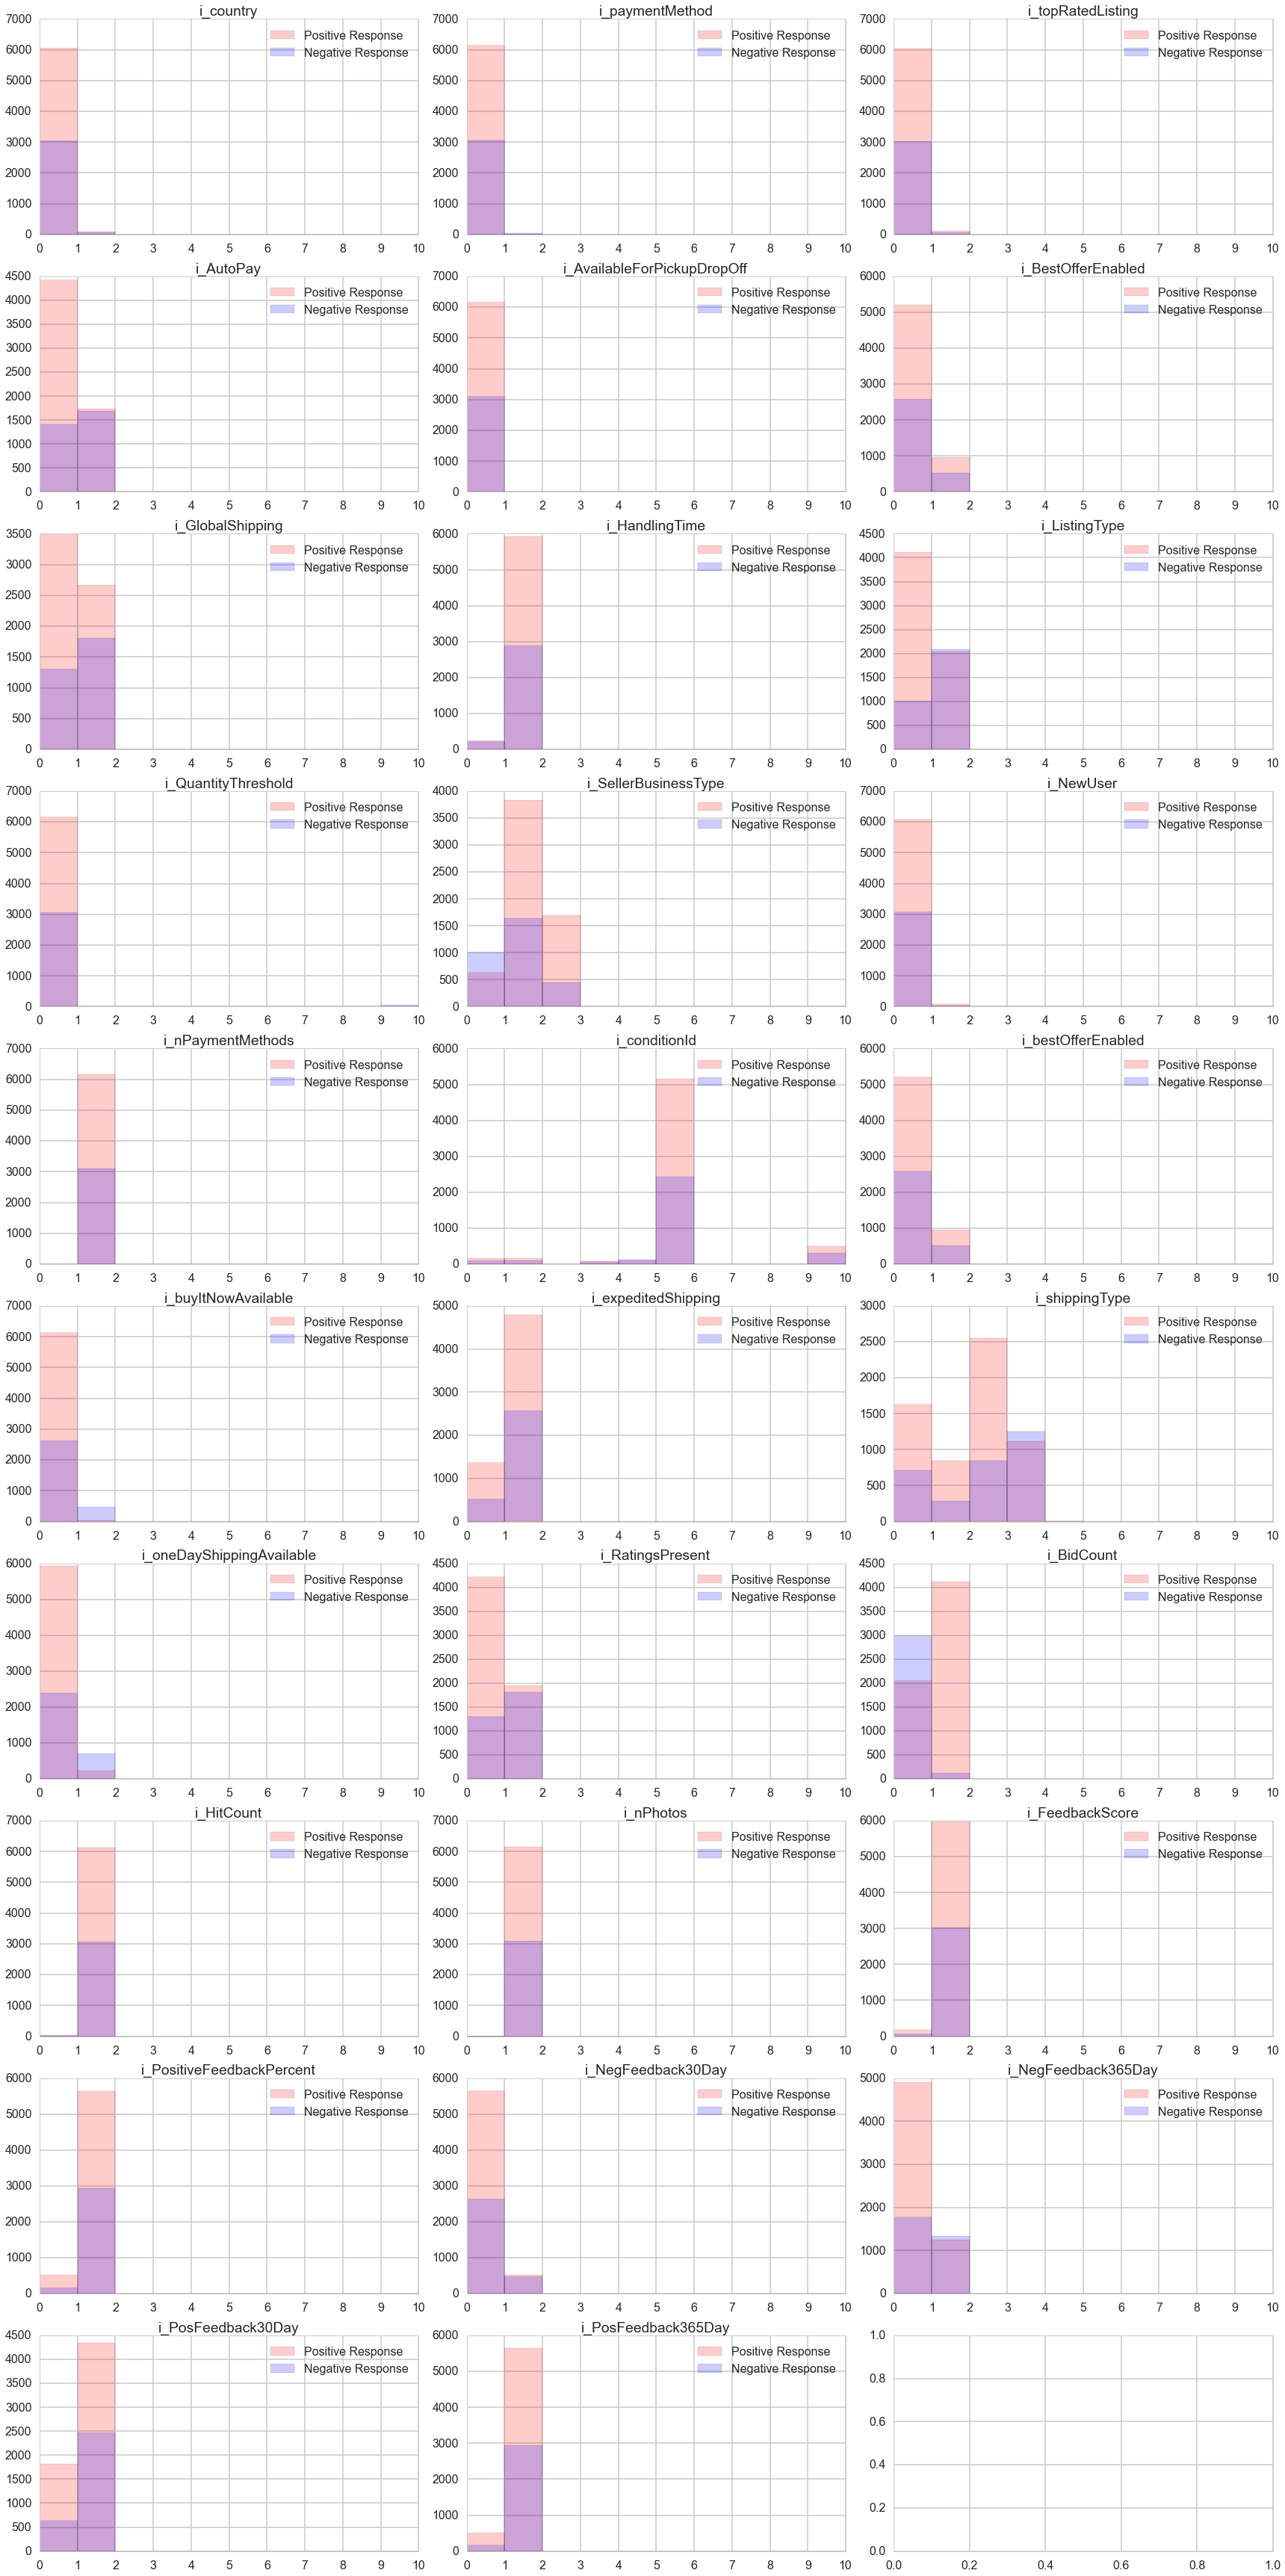

In [17]:
#setup similar layout
fig, axes = plt.subplots(nrows=10, ncols=3, figsize = (24,48),
                         tight_layout=True)

positives = dftouse[dftouse['sellingStatus'] == 0]
negatives = dftouse[dftouse['sellingStatus'] == 1]

for ax, data in zip(axes.ravel(), INDICATORS):
    ax.hist(positives[data].values, bins=10, range=[0,10], color = 'r', alpha = 0.2, label = 'Positive Response', rwidth=10)
    ax.hist(negatives[data].values, bins=10, range=[0,10], color = 'b', alpha = 0.2, label = 'Negative Response', bottom=1)
    ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
    ax.legend()
    ax.set_title(data)

In [18]:
from sklearn.svm import LinearSVC

In [19]:
lcols.remove('UserID')
lcols.remove('itemId')
lcols.remove('Title')
lcols.remove('ShipToLocations')
lcols.remove('Location')
lcols.remove('postalCode')
lcols.remove('ProductID')
lcols.remove('AverageRating')
lcols.remove('BuyItNowPrice')
lcols.remove('MinimumToBid')

In [20]:
clfsvm=LinearSVC(loss="hinge")
Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
Xmatrix=dftouse[lcols].values
Yresp=dftouse['FinalPrice'].values

In [21]:
Xmatrix_train=Xmatrix[mask]
Xmatrix_test=Xmatrix[~mask]
Yresp_train=Yresp[mask]
Yresp_test=Yresp[~mask]

In [22]:
#Xmatrix_train
from sklearn.grid_search import GridSearchCV
gsc = GridSearchCV(clfsvm,param_grid=dict(C=Cs), cv=5, scoring = "accuracy")
gsc.fit(Xmatrix_train, Yresp_train)
best = gsc.best_estimator_
best = best.fit(Xmatrix_train, Yresp_train)

ValueError: continuous is not supported

In [ ]:
param_acc = best.score(Xmatrix_train, Yresp_train)

In [ ]:
best

In [360]:
from sklearn.grid_search import GridSearchCV
def cv_optimize(clf, parameters, X, y, n_folds=5,score_func=None):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds,scoring=score_func)
    gs.fit(X, y)
    best = gs.best_estimator_
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    return best

In [361]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [362]:
%%time
clfsvm, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, dftouse,lcols, u'FinalPrice',1, mask=mask)

using mask
BEST {'C': 1.0} 0.803114400247 [mean: 0.71631, std: 0.03832, params: {'C': 0.001}, mean: 0.79217, std: 0.03351, params: {'C': 0.01}, mean: 0.79648, std: 0.04903, params: {'C': 0.1}, mean: 0.80311, std: 0.04887, params: {'C': 1.0}, mean: 0.80111, std: 0.04355, params: {'C': 10.0}, mean: 0.69457, std: 0.17928, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.85
Accuracy on test data:     0.84
[[1694  157]
 [ 287  643]]
########################################################
CPU times: user 13.8 s, sys: 146 ms, total: 13.9 s
Wall time: 16.3 s


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [363]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

In [364]:

##this tells us that most of our values are closer to 0 than 1, which means most were successful sales
print "whole data set", dftouse['FinalPrice'].mean()#Highly asymmetric
print "training set", dftouse['FinalPrice'][mask].mean(), "test set", dftouse['FinalPrice'][~mask].mean()

whole data set 0.334844070357
training set 0.335029293864 test set 0.334412081985


In [365]:
ypred=clfsvm.predict(Xtest)
confusion_matrix(ytest, ypred)

array([[1694,  157],
       [ 287,  643]])

In [366]:
print "OP=", ytest.sum(), ", ON=",ytest.shape[0] - ytest.sum()

OP= 930 , ON= 1851


In [367]:
print "PP=", ypred.sum(), ", ON=",ytest.shape[0] - ypred.sum()

PP= 800 , ON= 1981


In [368]:
#tnr stands for "true negative cost"
tnc= 0.0 

# taking approx. average cost of listing based on whether using images, bold, short burst shor auctions, etc
listing_fee = 4.2

## we calcluate how many of our listings are top rated listings assuming our data is an simple random sample to get
## a probability of a listing being a top rated listing
size_df = float(len(dftouse.index))
y = float(len(dftouse[dftouse['i_topRatedListing'] == True]))
prob_toprated = y/size_df   

## we get 90% of the profit from the sale, and if you are a top rated listing, you get %20 percent off this 10% charge
profit_margin=.9 +(.02 * prob_toprated) 


## We calculate the true positive cost using the listing fee and subtracting off the profit made. We have to 
## average over new or used to make the mean better weighted for the "value" of the iPhone. We take the used value to 
## be 70% of the new value based on the fact that Apple currently sells the new one for $500 and refurbished for $340
## BestBuy: http://www.bestbuy.com/site/apple-refurbished-iphone-5s-32gb-cell-phone-unlocked-silver/1311862035.p?id=mp1311862035&skuId=1311862035
## Apple New: http://www.apple.com/shop/buy-iphone/iphone5s/32gb-space-gray

new = float(len(dftouse[dftouse['i_conditionId'] == 0]))
prob_new = new/size_df
prob_used = 1 - prob_new
tpc = listing_fee - ((df.FinalPrice.mean())*prob_new + (df.FinalPrice.mean())*(.7 * prob_used))*profit_margin


## because we have no listing fee, our fnc is just (-tpc)
fnc = - tpc

## and our false positive cost is thus, what we would spend for listing when we shouldn't have
fpc = listing_fee

In [369]:
risk_matrix=np.array([[tnc, fpc],[fnc, tpc]])
risk_matrix

array([[   0.        ,    4.2       ],
       [ 159.07249097, -159.07249097]])

In [370]:
u = - risk_matrix

## to avoice writing -0
#u[0][0] = 0.
#u[0][1] = 0.
u

array([[  -0.        ,   -4.2       ],
       [-159.07249097,  159.07249097]])

In [371]:
def average_profit_pp(y, ypred, u):
    c=confusion_matrix(y,ypred)
    score=np.sum(c*u)/np.sum(c)
    return score

In [372]:
#baseline classifier #1: don't sell anything
testsize = dftouse[~mask].shape[0]
ypred_dste = np.zeros(testsize, dtype="int")
print confusion_matrix(ytest, ypred_dste)
dsteval=average_profit_pp(ytest, ypred_dste, u)
dsteval

[[1851    0]
 [ 930    0]]


-53.195762891125398

In [373]:
#baseline classifier #2: sell everything
testsize = dftouse[~mask].shape[0]
ypred_ste = np.ones(testsize, dtype="int")
print confusion_matrix(ytest, ypred_ste)
steval=average_profit_pp(ytest, ypred_ste, u)
steval

[[   0 1851]
 [   0  930]]


50.400293635461964

In [374]:
#calculating profit from SVM classifer using baselines
testsize = dftouse[~mask].shape[0]
ypred_svm=clfsvm.predict(Xtest)
print confusion_matrix(ytest, ypred_svm)
svmval=average_profit_pp(ytest, ypred_svm, u)
svmval

[[1694  157]
 [ 287  643]]


20.126000282128818

In [375]:
#logistic regression with Lasso based feature selection
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty="l1")
cvals = {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
clflog, Xtrain, ytrain, Xtest, ytest = do_classify(clf, cvals, dftouse,lcols, 'sellingStatus',1, mask=mask, reuse_split=reuse_split)

using mask
using reuse split
BEST {'C': 1.0} 0.806968855998 [mean: 0.66497, std: 0.00012, params: {'C': 0.001}, mean: 0.78554, std: 0.05097, params: {'C': 0.01}, mean: 0.80281, std: 0.03684, params: {'C': 0.1}, mean: 0.80697, std: 0.04228, params: {'C': 1.0}, mean: 0.80404, std: 0.04358, params: {'C': 10.0}, mean: 0.80358, std: 0.04384, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.86
Accuracy on test data:     0.86
[[1679  172]
 [ 229  701]]
########################################################


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [376]:
#calculating profit
testsize = dftouse[~mask].shape[0]
ypred_lreg=clflog.predict(Xtest)
print confusion_matrix(ytest, ypred_lreg)
lregval=average_profit_pp(ytest, ypred_lreg, u)
lregval

[[1679  172]
 [ 229  701]]


26.738516985575593

In [377]:
#Part 3
#function to make roc curves
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

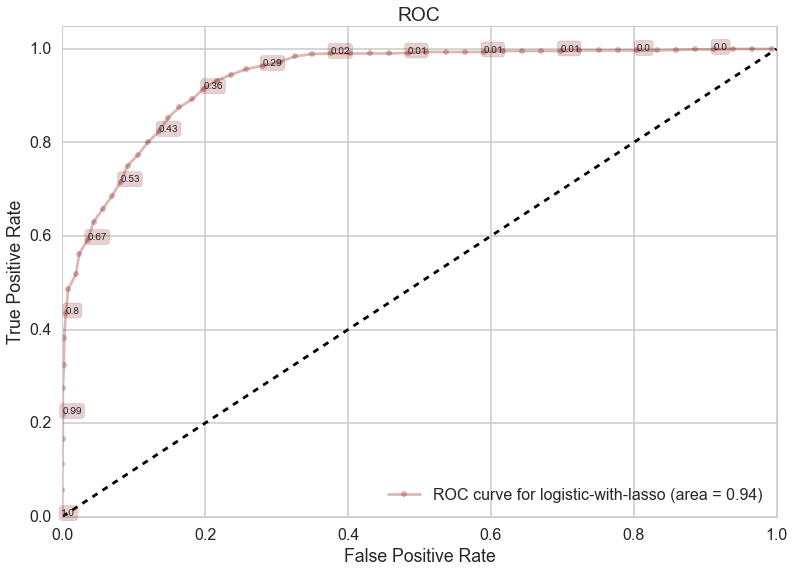

In [378]:
#logistic lasso ROC curve
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",clflog, ytest, Xtest, labe=200, skip=50)

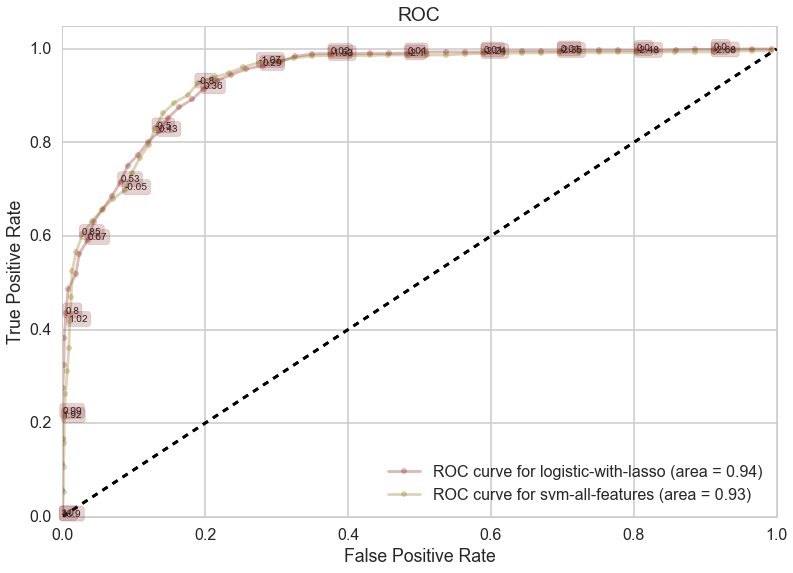

In [379]:
#logistic lasso vs. all features SVM
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",clflog, ytest, Xtest, labe=200, skip=50)
    make_roc("svm-all-features",clfsvm, ytest, Xtest, labe=200, proba=False, skip=50)

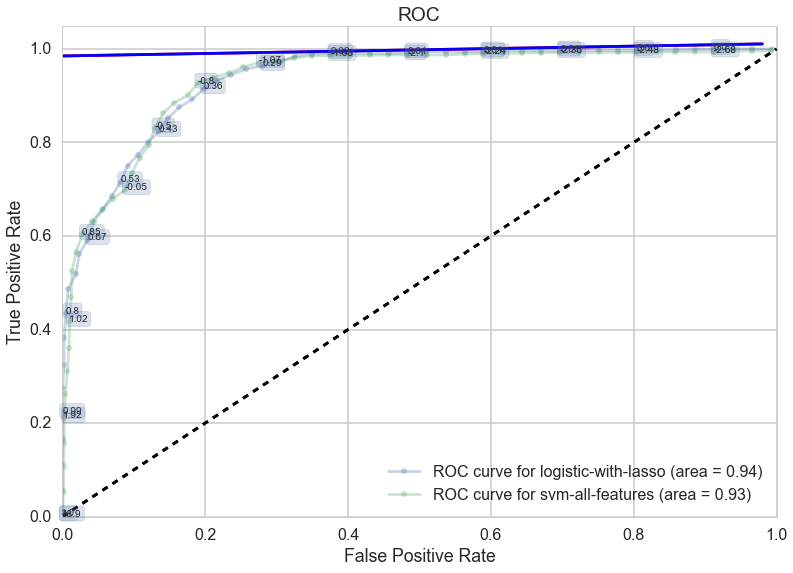

In [380]:
def rat(cost):
    return (cost[0,1] - cost[0,0])/(cost[1,0]-cost[1,1])
slope = rat(risk_matrix)*(np.mean(ytest==0)/np.mean(ytest==1))

z1=np.arange(0.,1., 0.02)
def plot_line(ax, intercept):
    plt.figure(figsize=(12,12))
    ax=plt.gca()
    ax.set_xlim([0.0,1.0])
    ax.set_ylim([0.0,1.0])
    make_roc("logistic-with-lasso",clflog, ytest, Xtest, labe=200, skip=50)
    make_roc("svm-all-features",clfsvm, ytest, Xtest, labe=200, proba=False, skip=50)
    ax.plot(z1 , slope*z1 + intercept, 'k-')

#from IPython.html.widgets import interact, fixed
#interact(plot_line, ax=fixed(ax), intercept=(0.0,1.0, 0.005))

make_roc("logistic-with-lasso",clflog, ytest, Xtest, labe=200, skip=50)
make_roc("svm-all-features",clfsvm, ytest, Xtest, labe=200, proba=False, skip=50)
#.82 corresponds to the intercept predicted by calling the interact function
plt.plot(z1, slope*z1+0.985,'r')
plt.plot(z1, slope*z1+0.985,'b')

In [381]:
def percentage(tpr, fpr, priorp, priorn):
    perc = tpr*priorp + fpr*priorn
    return perc

In [382]:
def av_profit(tpr,fpr,util,priorp,priorn):
    profit = priorp*(util[1][1]*tpr+util[1][0]*(1.-tpr))+priorn*(util[0][0]*(1.-fpr) +util[0][1]*fpr)
    return profit
# -tnc, -fpc, -fnc, -tpc

In [383]:
def make_profit(name, clf, ytest, xtest, util, ax=None, threshold=False, labe=200, proba=True):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    priorp=np.mean(ytest)
    priorn=1. - priorp
    ben=[]
    percs=[]
    for i,t in enumerate(thresholds):
        perc=percentage(tpr[i], fpr[i], priorp, priorn)
        ev = av_profit(tpr[i], fpr[i], util, priorp, priorn)
        ben.append(ev)
        percs.append(perc*100)
    ax.plot(percs, ben, '-', alpha=0.3, markersize=5, label='utlity curve for %s' % name)
    if threshold:
        label_kwargs = {}
        label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
        )
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (percs[k], ben[k]), **label_kwargs)
    ax.legend(loc="lower right")
    return ax

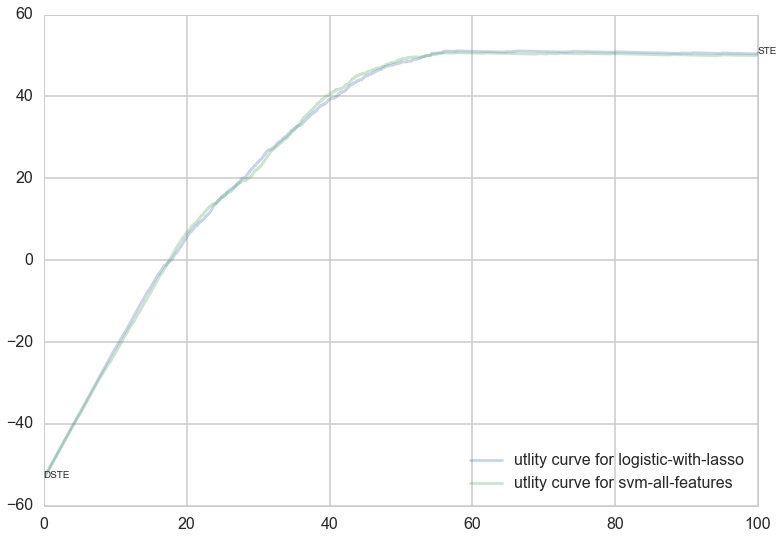

In [384]:
ax=make_profit("logistic-with-lasso", clflog, ytest, Xtest, u, ax=None, threshold=False, labe=200, proba=True)
make_profit("svm-all-features",clfsvm, ytest, Xtest, u, ax=None, threshold=False, labe=200, proba=False)
ax.annotate("STE",xy=(100,steval))
ax.annotate("DSTE",xy=(0,dsteval))

In [385]:
#Part 4
def nonzero_lasso(clf):
    featuremask=(clf.coef_ !=0.0)[0]
    return pd.DataFrame(dict(feature=lcols, coef=clf.coef_[0], abscoef=np.abs(clf.coef_[0])))[featuremask].sort('abscoef', ascending=False)

In [386]:
lasso_importances=nonzero_lasso(clflog)
lasso_importances.set_index("feature", inplace=True)
lasso_importances.head(10)

,abscoef,coef
feature,,
i_BidCount,10.449311,-10.449311
i_buyItNowAvailable,5.759065,5.759065
i_ListingType,5.284274,-5.284274
i_PositiveFeedbackPercent,2.092447,2.092447
i_paymentMethod,1.247231,1.247231
i_nPaymentMethods,1.132397,1.132397
i_topRatedListing,1.117599,-1.117599
i_oneDayShippingAvailable,0.866925,0.866925
i_nPhotos,0.841675,0.841675


In [387]:
from scipy.stats.stats import pearsonr
correlations=[]
dftousetrain=dftouse[mask]
for col in lcols:
    r=pearsonr(dftousetrain[col], dftousetrain['sellingStatus'])[0]
    correlations.append(dict(feature=col,corr=r, abscorr=np.abs(r)))

bpdf=pd.DataFrame(correlations).sort('abscorr', ascending=False)
bpdf.set_index(['feature'], inplace=True)
bpdf.head(25)

,abscorr,corr
feature,,
i_BidCount,0.601843,-0.601843
BidCount,0.346836,-0.346836
i_ListingType,0.330224,0.330224
i_buyItNowAvailable,0.302371,0.302371
i_oneDayShippingAvailable,0.290894,0.290894
i_RatingsPresent,0.264774,0.264774
i_AutoPay,0.262475,0.262475
i_SellerBusinessType,0.259541,-0.259541
i_NegFeedback365Day,0.230204,0.230204


In [388]:
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

In [389]:
def pearson_scorer(X,y):
    rs=np.zeros(X.shape[1])
    pvals=np.zeros(X.shape[1])
    i=0
    for v in X.T:
        rs[i], pvals[i]=pearsonr(v, y)
        i=i+1
    return np.abs(rs), pvals

In [390]:
selectorlinearsvm = SelectKBest(k=25, score_func=pearson_scorer)
pipelinearsvm = Pipeline([('select', selectorlinearsvm), ('svm', LinearSVC(loss="hinge"))])

In [391]:
pipelinearsvm, _,_,_,_  = do_classify(pipelinearsvm, {"svm__C": [0.00001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, dftouse,lcols, 'sellingStatus',1, reuse_split=reuse_split)

using reuse split
BEST {'svm__C': 100.0} 0.802343509097 [mean: 0.70120, std: 0.05684, params: {'svm__C': 1e-05}, mean: 0.72541, std: 0.04907, params: {'svm__C': 0.001}, mean: 0.78800, std: 0.04044, params: {'svm__C': 0.01}, mean: 0.79201, std: 0.05230, params: {'svm__C': 0.1}, mean: 0.79864, std: 0.05105, params: {'svm__C': 1.0}, mean: 0.80003, std: 0.05011, params: {'svm__C': 10.0}, mean: 0.80234, std: 0.06245, params: {'svm__C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.84
Accuracy on test data:     0.85
[[1711  140]
 [ 287  643]]
########################################################


In [392]:
np.array(lcols)[pipelinearsvm.get_params()['select'].get_support()]

array(['i_AutoPay', 'BidCount', 'i_GlobalShipping', 'HandlingTime',
       'i_ListingType', 'Quantity', 'i_QuantityThreshold', 'FeedbackScore',
       'i_SellerBusinessType', 'nPaymentMethods', 'nShippingCountries',
       'i_buyItNowAvailable', 'i_expeditedShipping', 'i_shippingType',
       'i_oneDayShippingAvailable', 'i_RatingsPresent',
       'NegFeedback365Day', 'PosFeedback30Day', 'PosFeedback365Day',
       'auctionLength', 'i_HandlingTime', 'i_BidCount',
       'i_NegFeedback30Day', 'i_NegFeedback365Day', 'i_PosFeedback30Day'], 
      dtype='|S27')

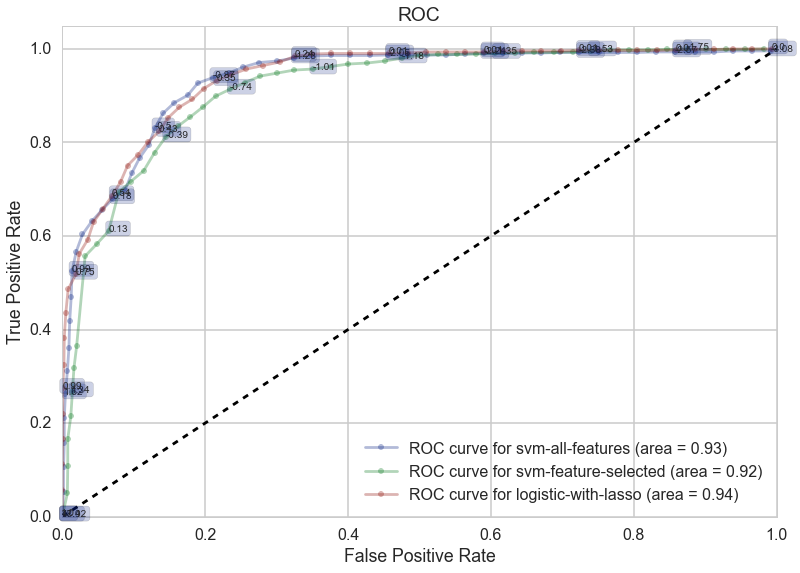

In [393]:
with sns.color_palette("dark"):
    ax=make_roc("svm-all-features",clfsvm, ytest, Xtest, None, labe=250, proba=False, skip=50)
    make_roc("svm-feature-selected",pipelinearsvm, ytest, Xtest, ax, labe=250, proba=False, skip=50);
    make_roc("logistic-with-lasso",clflog, ytest, Xtest, ax, labe=250, proba=True,  skip=50);

In [394]:
jtrain=np.arange(0, ytrain.shape[0])
n_pos=len(jtrain[ytrain==1])
n_neg=len(jtrain[ytrain==0])
print n_pos, n_neg


2173 4313


In [395]:
ineg = np.random.choice(jtrain[ytrain==0], n_pos, replace=False)

In [396]:
alli=np.concatenate((jtrain[ytrain==1], ineg))
alli.shape

(4346,)

In [397]:
Xtrain_new = Xtrain[alli]
ytrain_new = ytrain[alli]
Xtrain_new.shape, ytrain_new.shape

((4346, 44), (4346,))

In [398]:
reuse_split_new=dict(Xtrain=Xtrain_new, Xtest=Xtest, ytrain=ytrain_new, ytest=ytest)

In [399]:
clfsvm_b, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, dftouse,lcols, 'sellingStatus',1,reuse_split = reuse_split_new)

using reuse split
BEST {'C': 0.01} 0.819604233778 [mean: 0.77405, std: 0.04953, params: {'C': 0.001}, mean: 0.81960, std: 0.00686, params: {'C': 0.01}, mean: 0.78256, std: 0.07440, params: {'C': 0.1}, mean: 0.79475, std: 0.07008, params: {'C': 1.0}, mean: 0.72872, std: 0.13345, params: {'C': 10.0}, mean: 0.75173, std: 0.10876, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.82
Accuracy on test data:     0.76
[[1224  627]
 [  43  887]]
########################################################


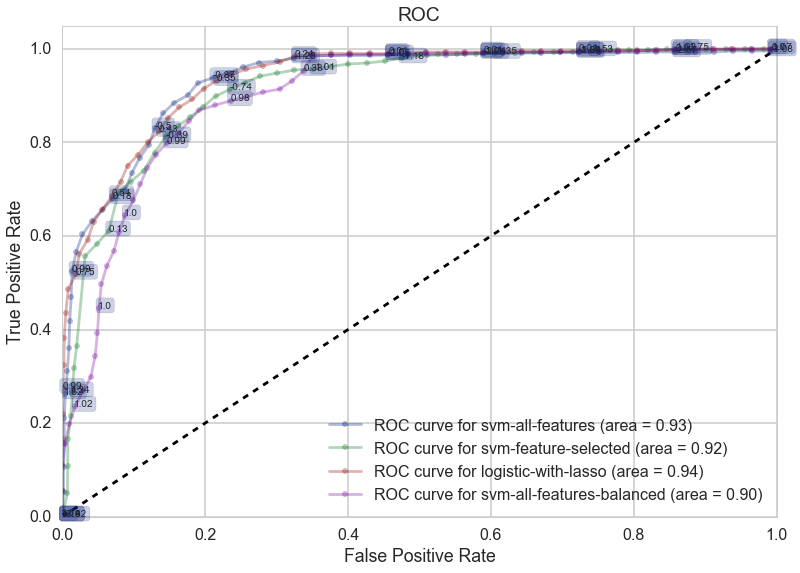

In [400]:
with sns.color_palette("dark"):
    ax=make_roc("svm-all-features",clfsvm, ytest, Xtest, None, labe=250, proba=False, skip=50)
    make_roc("svm-feature-selected",pipelinearsvm, ytest, Xtest, ax, labe=250, proba=False, skip=50);
    make_roc("logistic-with-lasso",clflog, ytest, Xtest, ax, labe=250, proba=True,  skip=50);
    make_roc("svm-all-features-balanced",clfsvm_b, ytest, Xtest, ax, labe=250, proba=False,  skip=50);

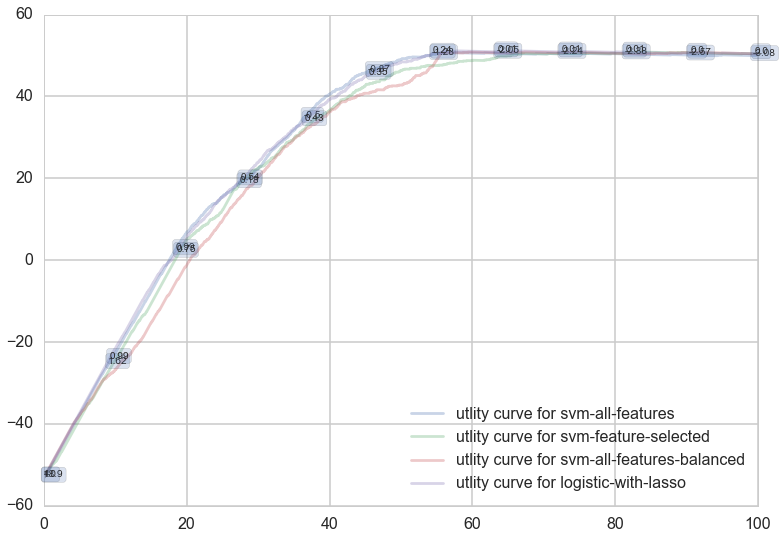

In [401]:
ax = make_profit("svm-all-features",clfsvm, ytest, Xtest, u, None, labe=250, threshold=True, proba=False)
make_profit("svm-feature-selected",pipelinearsvm, ytest, Xtest, u, ax, labe=250, proba=False);
make_profit("svm-all-features-balanced",clfsvm_b, ytest, Xtest, u, ax, labe=250, proba=False);
make_profit("logistic-with-lasso",clflog, ytest, Xtest, u, ax, labe=250, threshold=True);

In [402]:
from sklearn.svm import SVC

In [403]:
selectorsvm2 = SelectKBest(k=25, score_func=pearson_scorer)
pipesvm2 = Pipeline([('select2', selectorsvm2), ('svm2', SVC())])

In [404]:
jtrain_new=np.arange(0, ytrain_new.shape[0])
ipos_new = np.random.choice(jtrain_new[ytrain_new==1], 300, replace=False)
ineg_new = np.random.choice(jtrain_new[ytrain_new==0], 300, replace=False)
subsampled_i=np.concatenate((ipos_new,ineg_new))
Xtrain_new2=Xtrain_new[subsampled_i]
ytrain_new2=ytrain_new[subsampled_i]

In [405]:
reuse_split_subsampled=dict(Xtrain=Xtrain_new2, Xtest=Xtest, ytrain=ytrain_new2, ytest=ytest)

In [406]:
%%time
#your code here
params = {"svm2__C": [1e8], "svm2__gamma":[1e-9,1e-7,1e-5],"svm2__kernel":["rbf"]}
clfsvm_subsampled, Xtrain, ytrain, Xtest, ytest = do_classify(pipesvm2, params, dftouse,lcols, 'sellingStatus',1,reuse_split = reuse_split_subsampled)

using reuse split
BEST {'svm2__C': 100000000.0, 'svm2__gamma': 1e-05, 'svm2__kernel': 'rbf'} 0.826666666667 [mean: 0.66000, std: 0.03472, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-09, 'svm2__kernel': 'rbf'}, mean: 0.80000, std: 0.02173, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-07, 'svm2__kernel': 'rbf'}, mean: 0.82667, std: 0.02656, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-05, 'svm2__kernel': 'rbf'}]
############# based on standard predict ################
Accuracy on training data: 0.86
Accuracy on test data:     0.82
[[1481  370]
 [ 121  809]]
########################################################
CPU times: user 5.59 s, sys: 53.5 ms, total: 5.65 s
Wall time: 6.09 s


In [407]:
%%time
#your code here
selectorsvm3 = SelectKBest(k=25, score_func=pearson_scorer)
pipesvm3 = Pipeline([('select3', selectorsvm3), ('svm2', SVC(C=1e8,gamma=1e-9,kernel="rbf"))])
clfsvm_k, Xtrain, ytrain, Xtest, ytest = do_classify(pipesvm3, params, dftouse,lcols, 'sellingStatus',1,reuse_split = reuse_split_subsampled)

using reuse split
BEST {'svm2__C': 100000000.0, 'svm2__gamma': 1e-05, 'svm2__kernel': 'rbf'} 0.826666666667 [mean: 0.66000, std: 0.03472, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-09, 'svm2__kernel': 'rbf'}, mean: 0.80000, std: 0.02173, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-07, 'svm2__kernel': 'rbf'}, mean: 0.82667, std: 0.02656, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-05, 'svm2__kernel': 'rbf'}]
############# based on standard predict ################
Accuracy on training data: 0.86
Accuracy on test data:     0.82
[[1481  370]
 [ 121  809]]
########################################################
CPU times: user 5.74 s, sys: 48.8 ms, total: 5.79 s
Wall time: 6.23 s


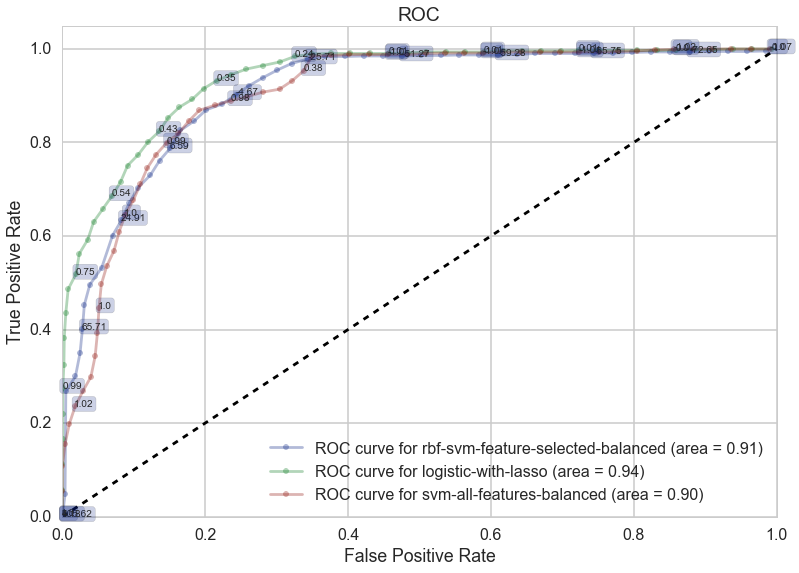

In [408]:
#Part 5
with sns.color_palette("dark"):
    ax=make_roc("rbf-svm-feature-selected-balanced",clfsvm_k, ytest, Xtest, None, labe=250, proba=False, skip=50)
    make_roc("logistic-with-lasso",clflog, ytest, Xtest, ax, labe=250, proba=True,  skip=50);
    make_roc("svm-all-features-balanced",clfsvm_b, ytest, Xtest, ax, labe=250, proba=False,  skip=50);

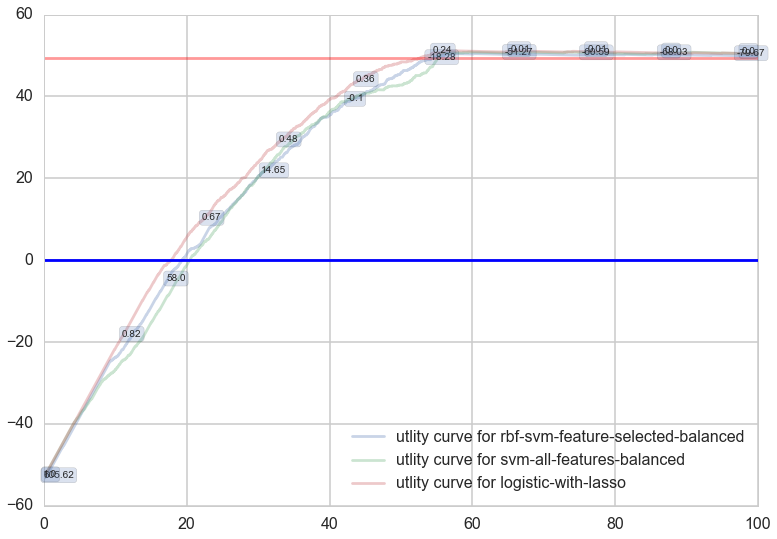

In [409]:
ax = make_profit("rbf-svm-feature-selected-balanced",clfsvm_k, ytest, Xtest, u, None, labe=300, threshold=True, proba=False)
#make_profit("svm-feature-selected",pipelinearsvm, ytest, Xtest, u, ax, labe=250, proba=False);
make_profit("svm-all-features-balanced",clfsvm_b, ytest, Xtest, u, ax, labe=300, proba=False);
make_profit("logistic-with-lasso",clflog, ytest, Xtest, u, ax, labe=300, threshold=True);
plt.axhline(49.5, color='red', alpha=.4)
plt.axhline(0, color='blue')